### Load dataset

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_talents():
    # Load csv dataset
    potential_talents_filepath = '../data/raw/potential-talents.xlsx'
    potential_talents = pd.read_excel(potential_talents_filepath)
    return potential_talents
potential_talents = load_talents()

In [12]:
potential_talents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


### Explore and transform dataset

In [13]:
potential_talents.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [3]:
# Remove the fit column
potential_talents.drop('fit',axis=1, inplace=True)

KeyError: "['fit'] not found in axis"

In [4]:
potential_talents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          104 non-null    int64 
 1   job_title   104 non-null    object
 2   location    104 non-null    object
 3   connection  104 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.4+ KB


In [3]:
# See unique values in the job_title feature
potential_talents.job_title.value_counts()

job_title
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
Aspiring Human Resources Professional                                                                                    7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
People Development Coordinator at Ryan                                                                                   6
Native English Teacher at EPIK (English Program in Korea)                                                                5
Aspiring Human Resources Specialist                                                                                      5
HR Senior Specialist                                                                                                     5
Student at Chapman University                                                                                            4
SVP, C

### Preprocessing

In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_candidate(row):
    # preserve id feature
    candidate_id = row['id']

    # Job Title Preprocessing
    title = row['job_title']
    # convert all characters to lowercase in order to standardize the text
    # Convert all characters to lowercase to standardize text
    text = title.lower()
    
    # Remove numbers and punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    
    # Tokenize text into words
    tokens = nltk.word_tokenize(text)
    
    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Abbreviation expansion
    abbreviation_map = {
        "dev": "developer",
        'chro': 'chief human resources officer',
        'svp': 'senior vice president',
        'gphr': 'global professional in human resources',
        'hris': 'human resources management system',
        'csr': 'corporate social responsibility',
        'sphr': 'strategic and policy-making certification',
        'hr': 'human resources',
        "mgr": "manager",
        "sr": "senior",
        "jr": "junior",
        "eng": "engineer",
        "asst": "assistant",
        "assoc": "associate",
        "admin": "administrator",
        "qa": "quality",
        "vp": "vicepresident",
    }
    # Replace words using abbreviation map dictionary 
    new_tokens = []
    for word in tokens:
        if word in abbreviation_map:
            new_tokens.append(abbreviation_map[word])
        else:
            new_tokens.append(word)

    tokens = new_tokens
    # After all cleaning steps, rejoin tokens into single string
    job_title_cleaned =  ' '.join(tokens)

    # Location Preprocessing 
    location = row['location'].lower().strip()
    location = re.sub(r'[^\w\s]', '', location)
    location = location.replace("türkiye", "turkey").replace("kanada", "canada")
    location = location.replace("amerika birleşik devletleri", "united states america")

    # Connection Preprocessing
    connection = row['connection']
    if isinstance(connection, str) and '500+' in connection:
        connection = 600
    else:
        try:
            connection = int(connection)
        except (ValueError, TypeError):
            connection = None 
    
    return {
        'id': candidate_id,
        'job_title': job_title_cleaned,
        'location': location,
        'connection': connection
    }

processed_potential_talents = potential_talents.apply(preprocess_candidate, axis=1, result_type='expand').drop_duplicates(subset=['job_title', 'location', 'connection'])
processed_potential_talents.to_csv('../data/interim/processed_potential_talents.csv', index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamesro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jamesro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jamesro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jamesro/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
processed_potential_talents = pd.read_csv('../data/interim/processed_potential_talents.csv')

In [6]:
processed_potential_talents.value_counts()

id   job_title                                                                                                                                                                                                                           location                            connection
1    ct bauer college business graduate magna cum laude aspiring human resource professional                                                                                                                                             houston texas                       85            1
79   liberal art major aspiring human resource analyst                                                                                                                                                                                   baton rouge louisiana area          7             1
81   senior human resource business partner heil environmental                                                                                        

In [6]:
from collections import Counter

job_titles = processed_potential_talents['job_title']

# initialize Counter
word_counts = Counter()

# Count words
for title in job_titles.dropna():
    for word in title.split():
        word_counts[word] += 1
# Print summary and top words
print('There are', len(word_counts), 'unique words in the job title column\n')

print("Top 20 Most Common Words in Job Titles:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")


There are 182 unique words in the job title column

Top 20 Most Common Words in Job Titles:
human: 39
resource: 34
aspiring: 13
professional: 11
seeking: 10
manager: 7
university: 6
student: 6
management: 6
business: 5
generalist: 5
resources: 5
specialist: 4
position: 4
senior: 3
system: 3
opportunity: 3
director: 3
major: 3
college: 2


From this we see that most common words in this job application list are 'human', 'resource', 'aspiring', 'professional', 'resources', 'student', 'seeking'.  

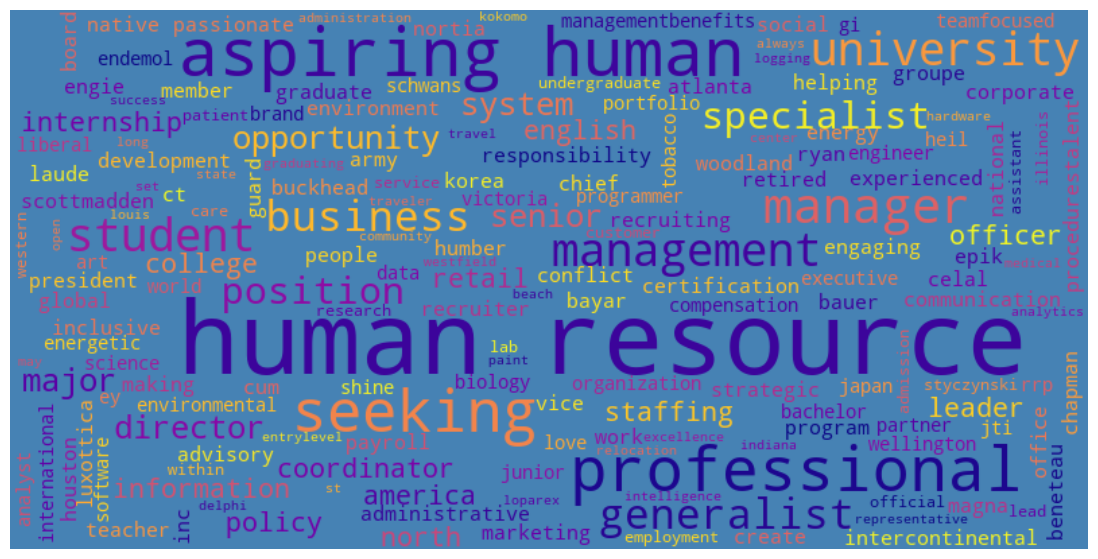

In [7]:
# Function to generate a word cloud from 'job_title' 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_word_cloud(job_titles):
    # combine all job titles into a single string
    text = ' '.join(job_titles.dropna())

    # generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='steelblue',
        colormap='plasma',
        max_words=200,
        random_state=42
    ).generate(text)

    # Plot the wordcloud
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    #plt.title('Job Title Word Cloud', fontsize=20)
    plt.show()

job_titles = processed_potential_talents['job_title']
plot_word_cloud(job_titles)

In [8]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Make sure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_user_keywords(job_title, location):
    # Job title preprocessing
    text = job_title.lower()    # Convert to lowercase
    text = re.sub(r'\d+', '', text)     # remove digits 
    text = text.translate(str.maketrans('','',string.punctuation))   # remove punctuation
    # split the string into tokens
    tokens = nltk.word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Abbreviation expansion
    abbreviation_map = {
        "dev": "developer",
        'chro': 'chief human resources officer',
        'svp': 'senior vice president',
        'gphr': 'global professional in human resources',
        'hris': 'human resources management system',
        'csr': 'corporate social responsibility',
        'sphr': 'strategic and policy-making certification',
        'hr': 'human resources',
        "mgr": "manager",
        "sr": "senior",
        "jr": "junior",
        "eng": "engineer",
        "asst": "assistant",
        "assoc": "associate",
        "admin": "administrator",
        "qa": "quality",
        "vp": "vicepresident",
    }
    # Replace words using abbreviation map dictionary 
    new_tokens = []
    for word in tokens:
        if word in abbreviation_map:
            new_tokens.append(abbreviation_map[word])
        else:
            new_tokens.append(word)

    tokens = new_tokens
    # After all cleaning steps, rejoin tokens into single string
    job_title_cleaned =  ' '.join(tokens)

    # Location Preprocessing 
    location_cleaned = location.lower().strip()
    location_cleaned = re.sub(r'[^\w\s]', '', location_cleaned)

    # Combine processed job_title and location into one string for vectorization
    combined_text = f"{job_title_cleaned} {location_cleaned}"
    
    return combined_text


[nltk_data] Downloading package punkt to /Users/jamesro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamesro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jamesro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Global User Entered KeyWords

In [9]:
# User enters keywords
user_job_title = "Aspiring Human Resources"
user_location = "North Carolina Area"
keyword = preprocess_user_keywords(user_job_title, user_location)
print(keyword)

aspiring human resource north carolina area


### Bag of Words
Method for converting text into numerical features that machine learnig models can understand. The key idea behind BoW is:
* It represents text data by counting the occurrence of each word in the text, disregarding grammar and word order but keeping track of word frequency.
* It creates a vocabulary of all unique words appearing in the dataset.
* Each text sample (in this project, a candidate’s job title or location) is represented as a vector whose length equals the size of this vocabulary.
* Each position in the vector shows how many times the corresponding word appears in the text sample.  
  
Why Use Bag of Words in This Project?  
In this project, we are predicting candidate fit based on features like job_title and location. Since these fields are text, machine learning models cannot directly use them unless they are transformed into numbers.

Bag of Words provides a simple, interpretable way to:

1. Quantify job title similarities: Candidates with job titles containing similar words will have similar vectors.

2. Capture important keywords: Words like “HR”, “Manager”, “Engineer”, or “Coordinator” directly affect a candidate’s potential fit for a role.

3. Enable similarity calculations: Once job titles are represented as vectors, you can compute cosine similarity between:

   * Candidate’s job title and the search keyword.

   * Candidate’s job title and the starred candidates’ job titles.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def rank_candidates_BoW(keyword, df):
    """ 
    Uses Bag of Words vectorization (BoW - CountVectorizer)
    Combine job_title and location per candidate into a single string
    Compute cosine similarity between candidates and a user provided keyword string
    Rank candidates by fit score and break ties by higher connection counts 
    """
    # Combine job_title and location into one feature for each candidate
    title_location = (df['job_title'] + ' ' + df['location']).astype(str).tolist()

    # Append user keyword to collection, to allow computing similarity between candidates and user query
    title_location.append(keyword)

    # Initialize CountVectorizer (Bag of Words)
    vectorizer = CountVectorizer()

    # fit and transform the collection, learning the vocab from the collection and creating a sparse word count matrix
    vectors = vectorizer.fit_transform(title_location)

    # compute cosine similarity (last vector is the keyword)
    # Between candidate vector which is (vectors[:-1] all except last row)
    # and keyword vector (vectors[-1], last row)
    cosine_sim = cosine_similarity(vectors[:-1], vectors[-1].reshape(1,-1))

    # Add cosine similarity as new column, use flatten() to convert 2D array into 1D array
    df['fit_BoW'] = cosine_sim.flatten()

    # Sort candidates by fit score, then by connection count
    ranked_candidates = df.sort_values(by=['fit_BoW', 'connection'], ascending = [False, False])
    #number of ranked candidates based on the keyword
    print('There are', ranked_candidates[ranked_candidates['fit_BoW']!=0].shape[0],'ranked candidates for the job',keyword)
    return ranked_candidates

ranked_candidates_df = rank_candidates_BoW(keyword, processed_potential_talents)
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_BoW.csv', index=False)


There are 42 ranked candidates for the job aspiring human resource north carolina area


In [10]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_BoW.csv')

In [11]:
ranked_candidates_df.head(10)

,id,job_title,location,connection,fit_BoW
0,3,aspiring human resource professional,raleighdurham north carolina area,44,0.866025
1,101,human resource generalist loparex,raleighdurham north carolina area,600,0.721688
2,71,human resource generalist scottmadden inc,raleighdurham north carolina area,600,0.680414
3,73,aspiring human resource manager seeking intern...,houston texas area,7,0.632456
4,97,aspiring human resource professional,kokomo indiana area,71,0.617213
5,6,aspiring human resource specialist,greater new york city area,1,0.544331
6,27,aspiring human resource management student see...,houston texas area,600,0.516398
7,82,aspiring human resource professional energetic...,austin texas area,174,0.516398
8,66,experienced retail manager aspiring human reso...,austin texas area,57,0.516398
9,72,business management major aspiring human resou...,monroe louisiana area,5,0.516398


### Term Frequency - Inverse Document Frequency (TF-IDF)
**TF-IDF (Term Frequency-Inverse Document Frequency)** is a text representation technique that builds on **Bag of Words (BoW)** but improves it by:

1. **Reducing the weight of common words** that appear frequently across many job titles (like "manager", "specialist").
2. **Boosting the importance of rare but potentially meaningful words** (like "zookeeper", "biostatistician") that may indicate more specific or unique roles.

TF-IDF combines two parts:

* **TF (Term Frequency):** Measures how often a word appears in a document (like BoW).
* **IDF (Inverse Document Frequency):** Measures how unique or rare a word is across all documents in the dataset.

**Formula:**

$$
\text{TF-IDF}(w, d) = \text{TF}(w, d) \times \text{IDF}(w)
$$

Where:

* $\text{TF}(w, d)$ = count of word $w$ in document $d$.
* $\text{IDF}(w) = \log \left( \frac{N}{n_w} \right)$,
  $N$ = total number of documents,
  $n_w$ = number of documents containing word $w$.

Thus, words that appear in **many job titles** get **lower scores**, while rare, distinguishing words get **higher scores**.

---
In this project, we’re dealing with job titles and locations as key text fields:

Many job titles share generic words: "human", "resources", "manager", "assistant".

TF-IDF reduces the influence of these words because they don’t help differentiate candidates.

Instead, TF-IDF gives more weight to specialized words like "zookeeper", "coordinator", "veterinary", or "analyst", which are better indicators of role-specific expertise.


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def rank_candidates_TF_IDF(keyword, df):
    """ 
    Uses TfidfVectorizer, computes cosine similarity between candidates and user keyword
    Appends the TF-IDF based fit score as new column to the passed dataframe
    """
    # combine job title and location for each candidate
    collection = (df['job_title'] + ' ' + df['location']).astype(str).tolist()

    # append the preprocessed keyword to the collection
    collection.append(keyword)

    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # fit and transform collection, vectorization
    vectors = tfidf_vectorizer.fit_transform(collection)

    # compute cosine similarity 
    cosine_sim = cosine_similarity(vectors[:-1], vectors[-1].reshape(1,-1))

    # Add TF-IDF cosine similarity score to Dataframe
    df['fit_tfidf'] = cosine_sim.flatten()

    # Sort by TF-IDF fit score and connection count for ranking
    ranked_candidates = df.sort_values(by=['fit_tfidf', 'connection'], ascending=[False, False])
    #number of ranked candidates based on the keyword
    print('There are', ranked_candidates[ranked_candidates['fit_tfidf']!=0].shape[0],'ranked candidates for the job',keyword)

    return ranked_candidates

ranked_candidates_df = rank_candidates_TF_IDF(keyword, ranked_candidates_df)
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_tfidf.csv', index=False)


There are 42 ranked candidates for the job aspiring human resource north carolina area


In [13]:
ranked_candidates_df = pd.read_csv('../data/interim/ranked_candidates_tfidf.csv')

In [14]:
ranked_candidates_df.head(10)

,id,job_title,location,connection,fit_BoW,fit_tfidf
0,3,aspiring human resource professional,raleighdurham north carolina area,44,0.866025,0.786660
1,101,human resource generalist loparex,raleighdurham north carolina area,600,0.721688,0.566225
2,71,human resource generalist scottmadden inc,raleighdurham north carolina area,600,0.680414,0.502023
3,73,aspiring human resource manager seeking intern...,houston texas area,7,0.632456,0.334853
4,97,aspiring human resource professional,kokomo indiana area,71,0.617213,0.303013
5,6,aspiring human resource specialist,greater new york city area,1,0.544331,0.260586
6,27,aspiring human resource management student see...,houston texas area,600,0.516398,0.252356
7,69,director human resource north america groupe b...,greater grand rapids michigan area,600,0.471405,0.240289
8,66,experienced retail manager aspiring human reso...,austin texas area,57,0.516398,0.231949
9,72,business management major aspiring human resou...,monroe louisiana area,5,0.516398,0.226746


### Word2Vec
Word2Vec is a shallow 1 hidden layer feed forward neural network based technique for learning dense vector representations of words. These vectors capture semantic meaning based on context. Words with similar meaning will have similar vectors. word2Vec learns embeddings by analyzing word co-occurence patterns in a large text corpora and produces low-dimensional dense vectors. There are two training approaches: Continuous Bag of Words which predicts a target word from its context and Skip-Gram which predicts surrounding words given a target word.  
I will be used a pre-trained Word2Vec model instead of training my own as our dataset is too small. Google News dataset will be ultizied as it is a huge dataset able to capture rich relationships. 

Google News Word2Vec is pretrained word embedding model developed by Google researchers in 2013. The model transforms individual words into dense vectors in a 300-dimensional space where semantic similarity is captured by vector distance. The architecture is a Skip-Gram series trained on the Google News dataset (~100 billion words). Skip-gram is preferred over CBOW in this instance for capturing semantic relationships in this smaller candidate dataset and better represents rare words. The skip-gram model learns to predict the surrounding words of a given target word. For example: Given the word "HR", it might learn to predict "recruiter", "human", "resources", "generalist", etc.  
As the project's goal is to rank candidates by how closely their job_title + location matches a search keyword like “aspiring human resources north carolina area”, Google News Word2Vec is useful because it is pretrained on massive data that captures general semantics of English very well. 

In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors

# Load pretrained Word2Vec (Google News)
# https://github.com/mmihaltz/word2vec-GoogleNews-vectors/blob/master/GoogleNews-vectors-negative300.bin.gz
google_w2v_model_filepath = "../models/GoogleNews-vectors-negative300.bin"
w2v_model = KeyedVectors.load_word2vec_format(google_w2v_model_filepath, binary=True)

def average_word2vec(text, model, embedding_dimension = 300):
    words = text.split()
    # if word exists in model's vocab, collect word vectors
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])

    # Compute the mean vector
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # else if no words found in vocab, returning zero vector
        return np.zeros(embedding_dimension)
        

def rank_candidates_Word2Vec(keyword, df, model):
    """ 
    Use pretrained Google News Word2ec embeddings
    Compute average Word2Vec vector for each candidate and user keyword
    Compute cosine simlarity and append fit bassed score
    """
    title_location = (df['job_title'] + ' ' + df['location']).astype(str).tolist()

    # Compute Word2Vec average vector for each candidate
    candidate_word2vec = np.array([average_word2vec(string, model) for string in title_location])

    # Compute Word2Vec vector for keyword
    keyword_word2vec = average_word2vec(keyword, model)

    # compute cosine similarity 
    cosine_sim = cosine_similarity(candidate_word2vec, keyword_word2vec.reshape(1,-1))  # reshape to convert keyword vector to 2d array

    # Add the word2vec fit score to the passing dataframe
    df['fit_w2v'] = cosine_sim.flatten()

    ranked_candidates = df.sort_values(by=['fit_w2v', 'connection'], ascending=[False, False])
    print('There are', ranked_candidates[ranked_candidates['fit_w2v']!=0].shape[0],'ranked candidates for the job',keyword)
    return ranked_candidates

ranked_candidates_df = rank_candidates_Word2Vec(keyword, ranked_candidates_df, w2v_model)   
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_W2V.csv', index=False)

There are 53 ranked candidates for the job aspiring human resource north carolina area


In [ ]:
ranked_candidates_df.head(10)

,id,job_title,location,connection,fit_BoW,fit_tfidf,fit_w2v
2,3,aspiring human resource professional,raleighdurham north carolina area,44,0.866025,0.786660,0.971718
100,101,human resource generalist loparex,raleighdurham north carolina area,600,0.721688,0.566225,0.895577
96,97,aspiring human resource professional,kokomo indiana area,71,0.617213,0.303013,0.846450
70,71,human resource generalist scottmadden inc,raleighdurham north carolina area,600,0.680414,0.502023,0.830086
72,73,aspiring human resource manager seeking intern...,houston texas area,7,0.632456,0.334853,0.803201
5,6,aspiring human resource specialist,greater new york city area,1,0.544331,0.260586,0.771752
71,72,business management major aspiring human resou...,monroe louisiana area,5,0.516398,0.226746,0.763616
73,74,human resource professional,greater boston area,16,0.500000,0.191058,0.752365
99,100,aspiring human resource manager graduating may...,cape girardeau missouri,103,0.456435,0.171685,0.742663
26,27,aspiring human resource management student see...,houston texas area,600,0.516398,0.252356,0.741470


In [20]:
# function for 1by3 plot for fit scores of the 3 vectorization methods
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_fit_score_histograms(df, columns, cols_per_row = 3, bins=10):
    """ 
    Create bar plots for fit scores of given vectorization methods
    columns = list of vectorizaton methods, ex: fit_BoW, fit_tf-idf...
    """
    total = len(columns)
    rows = math.ceil(total / cols_per_row)
    
    plt.figure(figsize=(5 * cols_per_row, 4 * rows))

    for i, col in enumerate(columns):
        plt.subplot(rows, cols_per_row, i+1)
        #plt.bar(range(len(df)), df[col])
        plt.hist(df[col].dropna(), bins=bins, edgecolor='black')
        plt.title(f'{col} Fit Score Distribution')
        plt.ylabel('Frequency')
        plt.xlabel('Cosine Similarity')
        plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

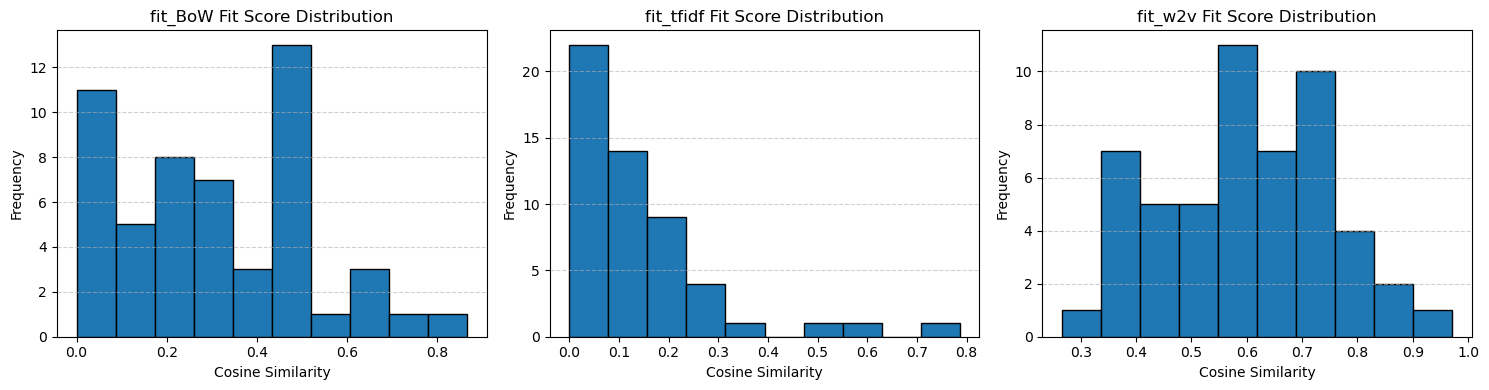

In [ ]:
plot_fit_score_histograms(ranked_candidates_df, ['fit_BoW', 'fit_tfidf', 'fit_w2v'])

Based on the fit scores for Google News Word2Vec, we see highly relevant job titles have fit score range from ~0.97 to 0.74. The candidates contain both semantic matches in job titles and sometimes geographical overlap. The model has good filtering of irrelevant candidates as they received low similarity scores as expected. As this method relies on averaging which reduces context, the model wil have trouble with multi-word phrase. The Google News Word2Vec model outperforms both BoW and TF-IDF as it captures semantic similarity beyond exact word match, gives higher scores to conceptually relevant profiles even if word usage differs.  

The histrograms show the distribution of cosine similarity scores from the following vectorization methods: Bag of Words, TF-IDF, and Word2Vec. Based on the BoW graph, the distribution is skewed left to low scores and a few moderate to high outliers. BoW depends on exact word overlap and many candidates have low or zero overlap with the keyword. The limitation of this method is that there is no understandin of meaning or context leading to poor generalization. The Term Frequency-Inverse Document Frequency historgram also shows a heavily left skewed distribution towards very low similarity range. Like BoW, TF-IDF relies on exact word match but boosts rare, informative words. This metho is still context insensitive and can not identify conceptual similarity. Word2Vec's fit distribution is more uniformly spread out. We can infer it captures semantic meaning, almost all candidates get non zero scores, and high scoring candidates are conceptually close even with different wording. Google's Word2Vec model has a strong ability to discriminate relevance on a conceptual level. 



### GloVe (Global Vectors for Word Representation)
GloVe (developed by Stanford NLP) is an unsupervised learning algorithm for generating dense vector representations of words (embeddings) based on word co-occurence statistics from a large corpus. Similar to Word2Vec, GloVe creates vector embeddings where semantically similar words have similar vectors but their training approach differs.  

The core idea of GloVe is that it can understand the meaning of a word by how often it co-occurs with other words, not just locally like Word2Vec, but globally across the corpus. At the heart of GloVe is a co-occurence matrix which is a glocal statiscal summary of how words appear together in a corpus. Its a square matrix X of size V by V where V  is the size of the vocabulary (number of unique words). The matrix is useful because the ratio of co-occurrence counts between two word pairs reveals semantic relationships. For example: $$\frac{X_{ice, solid}}{X_{ice,gas}} > \frac{X_{steam, solid}}{X_{steam,gas}}$$ reflects that 'Ice' is related to 'solid' and not 'gas' while 'steam' is related to 'gas' and not 'solid'. $w_i$ and context vectors $\tilde{w}_j$ such that:

$$
w_i^T \cdot \tilde{w}_j + b_i + \tilde{b}_j = \log(X_{ij})
$$

The model tries to ensure:

* The dot product of two word vectors matches the **log of how often they appear together** in the global corpus.

Using a pretrained GloVe model glove.6B.300d.txt, which is one of Stanford's NLP's official pretrained GloVe embeddings. The pretrained model "glove.6B.300d.txt" is trained on 6 billion tokens from a Wikipedia + Gigaword dataset where each word is represented by a 300-dimensional vector.


In [21]:
# load pretrained GloVe embedding glove.6B.300d.txt. Can find the file at Stanford NLP group's GloVe page
# https://nlp.stanford.edu/projects/glove/ 
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# function to convert .txt GloVe file into Word2Vec Format 
def convert_glove_to_word2vec(glove_file_path, word2vec_output_path):
    glove2word2vec(glove_file_path, word2vec_output_path)

# Load pretrained GloVe to return a KeyedVectors object
def load_glove_model(word2vec_output_path):
    model = KeyedVectors.load_word2vec_format(word2vec_output_path, binary=False)
    return model

# Average GloVe embedding for a candidate string
def get_average_glove(text, model, dim=300):
    """ 
    Transforms candidates text or keyword query into fixed size vector to allow for comparison
    between candidates and query in a shared embedding space and use cosine similarity
    """
    words = text.split()
    # collecting vectors for in-vocab words only, otherwise return 0 vector
    vectors = [model[word] for word in words if word in model]
    if vectors:
        return np.mean(vectors, axis=0)     # average across all words
    else:
        return np.zeros(dim)
    
def rank_candidates_GloVe(keyword, df, model, embedding_dim=300):
    """ 
    Rank candidates in in terms of semantic similarity to the user query using dense vector representation.
    """
    combined_text = (df['job_title'] + ' ' + df['location']).astype(str).tolist()

    # Compute average GloVe vector for both candidate and user query 
    candidate_vectors = np.array([get_average_glove(text, model, embedding_dim) for text in combined_text])
    keyword_vector = get_average_glove(keyword, model, embedding_dim)
    cosine_sim = cosine_similarity(candidate_vectors, keyword_vector.reshape(1, -1))
    df['fit_glove'] = cosine_sim.flatten()
    ranked_candidates = df.sort_values(by=['fit_glove', 'connection'], ascending=[False, False])
    print('There are', ranked_candidates[ranked_candidates['fit_glove']!=0].shape[0],'ranked candidates for the job',keyword)

    return ranked_candidates


In [22]:
glove_filepath = "../models/glove.6B.300d.txt"

# Convert the GloVe file once
convert_glove_to_word2vec(glove_filepath, "../models/glove.6B.300d.word2vec.txt")

# Load the converted file
glove_model = load_glove_model("../models/glove.6B.300d.word2vec.txt")

# Rank candidates
ranked_candidates_df = rank_candidates_GloVe(keyword, ranked_candidates_df, glove_model)
ranked_candidates_df.to_csv('../data/interim/ranked_candidates_GloVe.csv', index=False)


/var/folders/8y/bhm0868n4gq2p6yn4_gw1k6r0000gn/T/ipykernel_48504/1885870750.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file_path, word2vec_output_path)


There are 53 ranked candidates for the job aspiring human resource north carolina area


In [24]:
ranked_candidates_df.head(10)

,id,job_title,location,connection,fit_BoW,fit_tfidf,fit_w2v,fit_glove
2,3,aspiring human resource professional,raleighdurham north carolina area,44,0.866025,0.786660,0.971718,0.968006
100,101,human resource generalist loparex,raleighdurham north carolina area,600,0.721688,0.566225,0.895577,0.928789
70,71,human resource generalist scottmadden inc,raleighdurham north carolina area,600,0.680414,0.502023,0.830086,0.897873
5,6,aspiring human resource specialist,greater new york city area,1,0.544331,0.260586,0.771752,0.813920
72,73,aspiring human resource manager seeking intern...,houston texas area,7,0.632456,0.334853,0.803201,0.812859
73,74,human resource professional,greater boston area,16,0.500000,0.191058,0.752365,0.796382
71,72,business management major aspiring human resou...,monroe louisiana area,5,0.516398,0.226746,0.763616,0.788124
26,27,aspiring human resource management student see...,houston texas area,600,0.516398,0.252356,0.741470,0.786312
81,82,aspiring human resource professional energetic...,austin texas area,174,0.516398,0.219123,0.739183,0.784360
96,97,aspiring human resource professional,kokomo indiana area,71,0.617213,0.303013,0.846450,0.780231


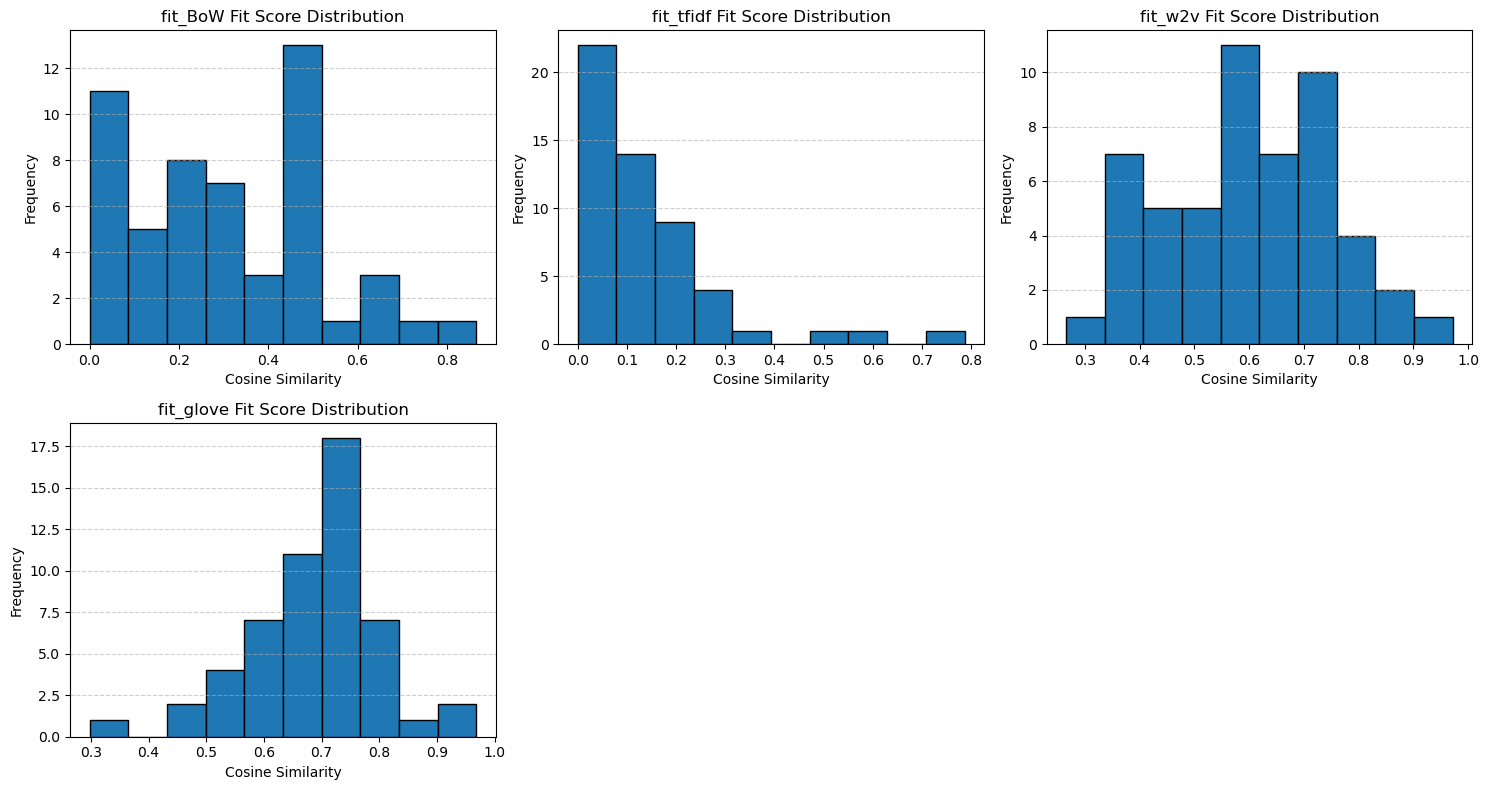

In [22]:
plot_fit_score_histograms(ranked_candidates_df, ['fit_BoW', 'fit_tfidf', 'fit_w2v', 'fit_glove'])

#### Visualizing GloVe results

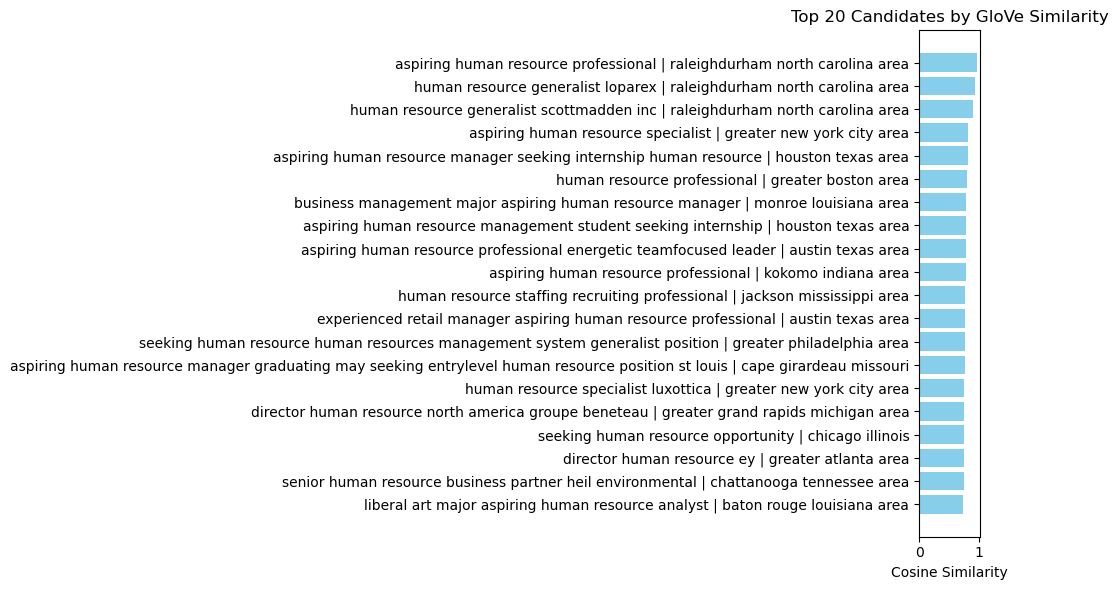

In [23]:
import matplotlib.pyplot as plt

def plot_glove_fit_scores(df, top_n=20):
    top_candidates = df.sort_values(by='fit_glove', ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_candidates['job_title'] + ' | ' + top_candidates['location'], top_candidates['fit_glove'], color='skyblue')
    plt.xlabel("Cosine Similarity")
    plt.title(f"Top {top_n} Candidates by GloVe Similarity")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_glove_fit_scores(ranked_candidates_df)

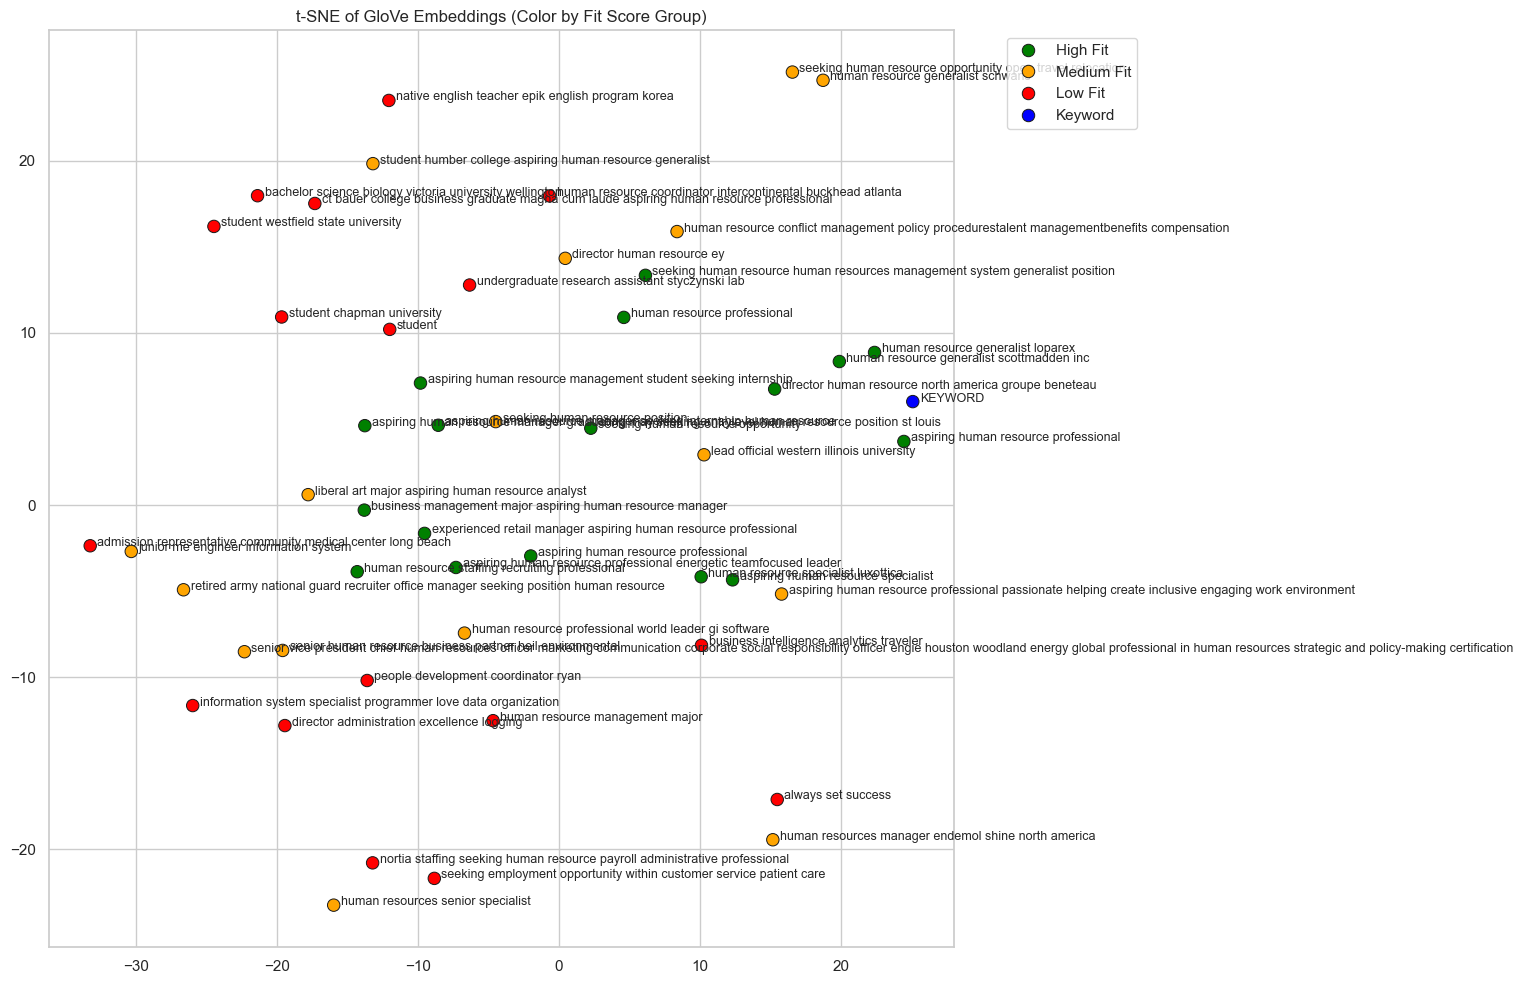

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_glove_embedding_by_fit(df, glove_model, keyword, top_n=50):
    """
    Visualize top candidate GloVe embeddings via t-SNE, color-coded into 3 groups based on fit score.
    """
    # Sample top candidates
    top_df = df.sort_values(by='fit_glove', ascending=False).head(top_n)
    combined = (top_df['job_title'] + ' ' + top_df['location']).tolist()

    # Compute GloVe vectors
    vectors = np.array([get_average_glove(text, glove_model) for text in combined])
    labels = top_df['job_title'].tolist()
    fit_scores = top_df['fit_glove'].tolist()

    # Categorize candidates into 3 bins based on fit score
    quantiles = np.quantile(fit_scores, [0.33, 0.66])
    fit_groups = []
    for score in fit_scores:
        if score <= quantiles[0]:
            fit_groups.append('Low Fit')
        elif score <= quantiles[1]:
            fit_groups.append('Medium Fit')
        else:
            fit_groups.append('High Fit')

    # Append keyword
    keyword_vec = get_average_glove(keyword, glove_model)
    vectors = np.vstack([vectors, keyword_vec])
    labels.append('KEYWORD')
    fit_groups.append('Keyword')

    # Reduce to 2D
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    tsne_result = tsne.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(14, 10))
    palette = {'Low Fit': 'red', 'Medium Fit': 'orange', 'High Fit': 'green', 'Keyword': 'blue'}
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                    hue=fit_groups, palette=palette, s=80, edgecolor='k')

    # Annotate each point with label
    for i, label in enumerate(labels):
        plt.text(tsne_result[i, 0] + 0.5, tsne_result[i, 1], label, fontsize=9)

    plt.title("t-SNE of GloVe Embeddings (Color by Fit Score Group)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_glove_embedding_by_fit(ranked_candidates_df, glove_model, keyword)


### Using t-Distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is a nonlinear dimensionality reduction algorithm used to visualize high-dimensional data in 2D or 3D by preserving local similarities. Word embeddings (GloVe) are high-dimensional 300D, and we can't visualize 300D space directly. t-SNE reduces these to 2D while preserving the structure of word similarity (local neighborhoods). Computes pairwise similarities between points in high-dimensional space (based on a probability distribution over neighbors). Then it projects the data into a low-dimensional space (2D or 3D). Minimizes the divergence between the two distributions (high-D and low-D) using Kullback-Leibler (KL) divergence. Uses a heavy-tailed Student-t distribution in the low-dimensional space to avoid crowding.

In [2]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

def plot_glove_embedding_tSNE(df, glove_model, keyword, top_n=50):
    """ 
    Visualize semantic similarity of candidates vs target keyword using averaged GloVe embeddings via 
    t-Distributed Stochastic Neighbor Embedding (t-SNE), color coded into 3 groups based on fit score.
    """
    top_candidates = df.sort_values(by='fit_glove', ascending=False).head(top_n)
    combined_text = (top_candidates['job_title'] + ' ' + top_candidates['location']).tolist()

    # Compute GloVe embeddings 
    vectors = np.array(get_average_glove(text, glove_model) for text in combined_text)
    # extracting job titles and fit scores for labeling and grouping
    labels = top_candidates['job_title'].tolist()
    fit_scores = top_candidates['fit_glove'].tolist()

    # Group Glove Fit scores into categories 3 way split 33% each
    quantiles = np.quantile(fit_scores, [0.33, 0.66])
    fit_groups = []
    for score in fit_scores:
        if score <= quantiles[0]:
            fit_groups.append('Low Fit')
        elif score <= quantiles[1]:
            fit_groups.append('Medium Fit')
        else:
            fit_groups.append('High Fit')

    # Append user keyword to the plot
    keyword_vector = get_average_glove(keyword, glove_model)
    vectors = np.vstack([vectors, keyword_vector])
    labels.append('KEYWORD')
    fit_groups.append('Keyword')

    # Reduce Dimensionality using t-SNE, reduce 300D embeddings to 2D
    # n_components=2 to project into 2D, perplexity=5, low since sample size is small
    tsne=TSNE(n_components=2, perplexity=5, random_state=432)
    tsne_result = tsne.fit_transform(vectors)

    # Plotting result with Seaborn
    plt.figure(figsize=(14,10))
    palette = {'Low Fit':'red', 'Medium Fit':'orange','High Fit':'green','Keyword':'blue'}
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=fit_groups, palette=palette, s=80, edgecolor='k')

    # Annotate points with Job Titles
    texts = []
    for i,label in enumerate(labels):
        texts.append(plt.text(tsne_result[i,0], tsne_result[i,1], label, fontsize=9))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

    plt.title('t-SNE of GloVe Embeddings (Color by Fit Score Group)', fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_glove_embedding_tSNE(ranked_candidates_df, glove_model, keyword)


NameError: name 'ranked_candidates_df' is not defined

### FastText  
Developed by Facebook AI Research (FAIR), FastText is a word embedding model 